In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import pickle
from torch.utils.data import Dataset, TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler
from scipy import stats
from tqdm import tqdm
# from skbio.stats.composition import clr
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'mps')
print(device)

from utils import *

import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 14

cuda:0


#### Preprocess synthetic data

In [2]:
def save_preprocessed(p_data, name_data):
    data_df=pickle.load(open(p_data, "rb"))
    idx, data_df = data_df.iloc[:, :1], data_df.iloc[:, 1:]

    # filter the data and remove low abundance species
    min_thres = 1e-5
    data_df[data_df<=min_thres]=0
    n_samples = data_df.shape[0]
    data_df = data_df.loc[:, (data_df>0).sum(axis=0) >= 0.05*n_samples]

    ## normalize to relative abundance
    data_df = data_df.div(data_df.sum(axis=1), axis=0)

    ## separate train and test
    features = (data_df>0).values.astype(float)
    labels = data_df.values
    print(f"{features.shape[0]} samples, {features.shape[1]} families") 
    
    ## save preprocessed data
    torch.save({"features":features, "labels":labels, "names":list(data_df.columns)}, f"../data/{name_data}_filtered.pt")
    
save_preprocessed("../synthetic_data/data_v1/all_diets.pkl", "synthetic_v1")

10000 samples, 54 families


### Load, split and normalize

In [3]:
def load_filtered_data(p_data):
    features = torch.load(p_data)["features"]
    labels = torch.load(p_data)["labels"]
    spc_names = torch.load(p_data)["names"]
    
    original_indices = np.arange(len(features))
    train_indices, test_indices = train_test_split(
        original_indices,
        test_size=0.2,
        random_state=42,
    )
    X_train = features[train_indices]
    X_test = features[test_indices]
    y_train = labels[train_indices]
    y_test = labels[test_indices]
#     X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    ## clr transformation for outputs
    zero_thr = 1e-8
    gmean_train = (np.exp(np.nansum(np.log(y_train[y_train > 0]+zero_thr)) / np.size(y_train)))
    y_train_clr = np.log((y_train+zero_thr)/gmean_train)
    y_test_clr = np.log((y_test+zero_thr)/gmean_train)

    ## rescale the data
    scaler = preprocessing.MaxAbsScaler().fit(y_train_clr)
    # scaler = preprocessing.RobustScaler().fit(y_train_clr)
    y_train_scaled = scaler.transform(y_train_clr)
    y_test_scaled = scaler.transform(y_test_clr)

    ## transform to tensors
    X_train_scaled=torch.from_numpy(X_train).float()
    y_train_scaled=torch.from_numpy(y_train_scaled).float()
    X_test_scaled=torch.from_numpy(X_test).float()
    y_test_scaled=torch.from_numpy(y_test_scaled).float()

#     plt.hist(y_test_scaled.numpy().flatten(), bins=40)
#     plt.yscale("log")
#     plt.xlabel("Abundance score")
#     plt.ylabel("Counts")
#     plt.show()
    
    # keep the spc names and train/test split for evaluation use
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, {"spcs":spc_names,
                                                                          "train_idx": train_indices, 
                                                                          "test_idx": test_indices}

### Apply autoencoder

In [4]:
class VAETrainer:
    def __init__(self, model, train_loader, test_loader, optimizer, weights, device="cuda:0"):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.weights = weights
        self.device = device

    def train_one_epoch(self, zero_thr):
        self.model.train()
        total_loss, total_recon_loss, total_bce_loss, total_kl_loss = 0, 0, 0, 0
        total_acc = 0
        total_len = 0
        for batch in self.train_loader:
            batch['Features'], batch['Labels'] = batch['Features'].to(device), batch['Labels'].to(device)
            
            self.optimizer.zero_grad()
#             recon_x, loss, recon_loss, kl_loss = compute_loss(self.model, batch['Features'], batch['Labels'], self.weights)
            b, nb, loss, recon_loss, bce_loss, kl_loss = compute_loss_2(self.model, batch['Features'], batch['Labels'], self.weights)
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_bce_loss += bce_loss.item()
            total_kl_loss += kl_loss.item()
            
#             out = ((recon_x.detach())>zero_thr).float()
            out = (b.detach()>0.5).float()
            total_acc += (out == batch['Features']).float().sum().item() # for binary-abundance
            total_len += batch["Features"].shape[0]

        return total_loss / total_len, \
               total_recon_loss / total_len, \
               total_bce_loss / total_len, \
               total_kl_loss / total_len, \
               total_acc / total_len / batch["Features"].shape[1]

    @torch.no_grad()
    def test_one_epoch(self, zero_thr):
        self.model.eval()
        total_loss, total_recon_loss, total_bce_loss, total_kl_loss = 0, 0, 0, 0
        total_acc = 0
        total_len = 0
        for batch in self.test_loader:
            batch['Features'], batch['Labels'] = batch['Features'].to(device), batch['Labels'].to(device)
            
#             recon_x, loss, recon_loss, kl_loss = compute_loss(self.model, batch['Features'], batch['Labels'], self.weights)
            b, nb, loss, recon_loss, bce_loss, kl_loss = compute_loss_2(self.model, batch['Features'], batch['Labels'], self.weights)
            
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_bce_loss += bce_loss.item()
            total_kl_loss += kl_loss.item()
            
#             out = ((recon_x.detach())>zero_thr).float()
            out = (b.detach()>0.5).float()
            total_acc += (out == batch['Features']).float().sum().item() # for binary-abundance
            total_len += batch["Features"].shape[0]

        return total_loss / total_len, \
               total_recon_loss / total_len, \
               total_bce_loss / total_len, \
               total_kl_loss / total_len, \
               total_acc / total_len / batch["Features"].shape[1]

In [5]:
def train_VAE_on_data(p_data, p_output, weights=[1.0, 1.0, 0.0]):
    '''
    weights: recon abundance loss; presence bce loss; KL divergence. 
    '''
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, annotations = load_filtered_data(p_data)
    spc_names = annotations["spcs"]
    class CustomDataset(Dataset):
        def __init__(self, features, labels, device=None):
            self.labels = labels
            self.features = features
        def __len__(self):
            return len(self.labels)
        def __getitem__(self, idx):
            label = self.labels[idx]
            data = self.features[idx]
            return {"Features": data, "Labels": label}
    Train = CustomDataset(X_train_scaled, y_train_scaled)
    Test = CustomDataset(X_test_scaled, y_test_scaled)

    input_dim = len(spc_names)
    hidden_dim = 2048
    latent_dim = 25
    epochs = 150
    lr = 1e-3
    weight_decay = 1e-4
    zero_thr = -0.8
    
#     # early stopping
#     patience = 10 
#     min_delta = 1e-3
#     best_loss = float('inf')
#     epochs_no_improve = 0
#     best_model_state = None

    model = VAE_2(input_dim, latent_dim, hidden_dim).to(device)
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=lr,
        weight_decay=weight_decay
    )

    ## create batch spits of data
    kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    train_DS = DataLoader(Train, batch_size=100, shuffle=True, drop_last=False, **kwargs)
    test_DS = DataLoader(Test, batch_size=100, shuffle=True, drop_last=False, **kwargs)

    trainer = VAETrainer(model, train_DS, test_DS, optimizer, weights, device)

    train_losses = []
    test_losses = []
    train_acc = []
    test_acc = []
    MSEs, BCEs, KLDs = [], [], []
    for epoch in tqdm(range(epochs)):
        train_loss, MSE, BCE, KLD, acc = trainer.train_one_epoch(zero_thr)
        train_losses.append(train_loss)
        train_acc.append(acc)

        test_loss, MSE, BCE, KLD, acc = trainer.test_one_epoch(zero_thr)
        test_losses.append(test_loss)
        test_acc.append(acc)
        MSEs.append(MSE)
        BCEs.append(BCE)
        KLDs.append(KLD)
        
    torch.save({"model":model.state_dict(), "annotations":annotations}, p_output)        
        
    ## plot the training process
    train_acc=np.array(train_acc)
    test_acc = np.array(test_acc)
    plt.plot(range(train_acc.shape[0]), train_acc*100, c='blue', label = "train_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy, %")
    plt.ylim([0, 100])
    #     plt.xlim([0,1000])  # adjust the right leaving left unchanged
    plt.plot(range(test_acc.shape[0]), test_acc*100, c='red', label = "test_acc")
    prevalence=np.sum(X_train_scaled.numpy(), axis=0)/X_train_scaled.shape[0]
    prevalence[prevalence>=0.5]=1
    prevalence[prevalence<0.5]=0
    # horizontal line showing dumb predictions based on prevalence
    acc=(1-np.sum(np.abs(X_test_scaled.numpy()-prevalence))/X_test_scaled.shape[0]/prevalence.shape[0])*100
    plt.axhline(y = acc, color = 'orange', linestyle = '-.')
    plt.legend(frameon=False)
    handle = p_data.split("/")[-1][:-3]
    plt.savefig(f"../figures/trainingproc_acc_{handle}.pdf", bbox_inches="tight")
    plt.show()

    # show the losses
    lists = [MSEs, BCEs, KLDs]
    names = ["MSE", "Binary", "KLD"]
    for (yloss, loss_name) in zip(lists, names):
        plt.plot(range(train_acc.shape[0]), yloss, label=loss_name)
    plt.legend(frameon=False)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.yscale("log")
    handle = p_data.split("/")[-1][:-3]
    plt.savefig(f"../figures/trainingproc_loss_{handle}.pdf", bbox_inches="tight")
    plt.show()

100%|██████████| 150/150 [02:58<00:00,  1.19s/it]
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


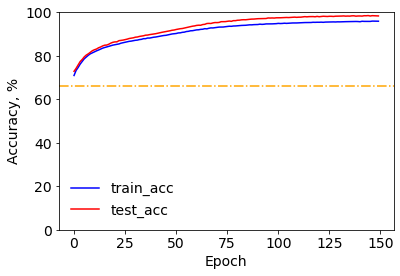

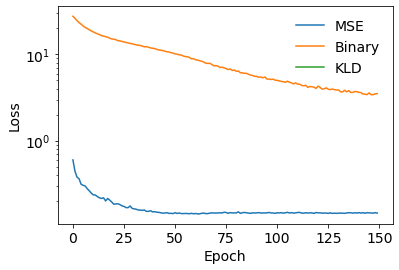

In [6]:
train_VAE_on_data("../data/synthetic_v1_filtered.pt", "../models/synthetic_v1_trained_AE.pt", weights=[1.0, 1.0, 0.0])

In [7]:
# compare initial and reconstructed features
plt.figure(figsize=(4, 3))
plt.hist(y_test_scaled.numpy().flatten(), bins=40, alpha=0.2, label="True")
all_recon = []
for batch in test_DS:
#     recon_x, loss, recon_loss, kl_loss = compute_loss(model, batch['Features'].to(device), batch['Labels'].to(device), weights)
#     recon_x = recon_x.detach().cpu().numpy().flatten()
#     recon_x[recon_x<zero_thr] = -1
    b, nb, loss, recon_loss, bce_loss, kl_loss = compute_loss_2(model, batch['Features'].to(device), batch['Labels'].to(device), weights)
    recon_x = (b>0.5).float()*nb + (b<0.5).float()*(-1)
    # recon_x = nb
    recon_x = recon_x.detach().cpu().numpy().flatten()
    all_recon.extend(list(recon_x))
plt.hist(all_recon, bins=40, alpha=0.4, label="Pred")
plt.yscale("log")
plt.legend()
plt.show()

print(y_test_scaled.numpy().flatten().shape, len(all_recon))

NameError: name 'y_test_scaled' is not defined

<Figure size 288x216 with 0 Axes>

In [ ]:
# check the reconstruction values
true_x_list = []
recon_x_list = []
n_batch_use = 20

for (idx, batch) in enumerate(test_DS):
    true_x = batch['Labels'].detach().numpy()
#     recon_x, u, logvar = model(batch['Features'].to(device))
#     recon_x = recon_x.detach().cpu().numpy()
    b, nb, loss, recon_loss, bce_loss, kl_loss = compute_loss_2(model, batch['Features'].to(device), batch['Labels'].to(device), weights)
    recon_x = (b>0.5).float()*nb + (b<0.5).float()*(-1)
    recon_x = recon_x.detach().cpu().numpy()
    true_x_list.append(true_x)
    recon_x_list.append(recon_x)
    if(idx>=n_batch_use):
        break
        
true_x_list = np.vstack(true_x_list)
recon_x_list = np.vstack(recon_x_list)
plt.figure(figsize=(4, 3))
plt.hist2d(x=true_x_list.flatten(), y=recon_x_list.flatten(), norm=matplotlib.colors.PowerNorm(1/10), cmap='viridis', bins=100)
plt.plot([-1.0, 0.2], [-1.0, 0.2], color="r")
plt.xlabel("True")
plt.ylabel("Pred")
plt.show()

# spearman r by species
coeffs = [ stats.spearmanr(true_x_list[:, i], recon_x_list[:, i]) for i in range(true_x_list.shape[1]) ]
coeffs_sorted = sorted(enumerate(coeffs), key=lambda x: x[1], reverse=True)
plt.figure(figsize=(4, 3))
plt.scatter(range(len(coeffs)), [val[0] for (idx, val) in coeffs_sorted], color="k", alpha=0.2)
plt.xlabel("Rank")
plt.ylabel("Spearman r of each species")
plt.show()

# top x best predicted species
for i in range(20):
    print(coeffs_sorted[i][1][0], data_df.columns[coeffs_sorted[i][0]])
    
# predictibility vs prevalence
plt.figure(figsize=(4, 3))
plt.scatter([np.sum(data_df.values[:, i]>0)/data_df.values.shape[0] for i in range(data_df.shape[1])], \
             [i[0] for i in coeffs])
plt.xlabel("Prevalence")
plt.ylabel("Spearman r")

## Deprecated; might be useful afterwards

#### how does it compare to other methods?

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

In [70]:
rfcc = []
encc = []
vaecc = []
# Do 10 random splits
for split in range(1):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=split)
    ## clr transformation for outputs
    zero_thr = 1e-8
    gmean_train = (np.exp(np.nansum(np.log(y_train[y_train > 0]+zero_thr)) / np.size(y_train)))
    y_train_clr = np.log((y_train+zero_thr)/gmean_train)
    y_test_clr = np.log((y_test+zero_thr)/gmean_train)

    ## rescale the data
    scaler = preprocessing.MaxAbsScaler().fit(y_train_clr)
    # scaler = preprocessing.RobustScaler().fit(y_train_clr)
    y_train_scaled = scaler.transform(y_train_clr)
    y_test_scaled = scaler.transform(y_test_clr)

    ## transform to tensors
    X_train_scaled=torch.from_numpy(X_train).float()
    y_train_scaled=torch.from_numpy(y_train_scaled).float()
    X_test_scaled=torch.from_numpy(X_test).float()
    y_test_scaled=torch.from_numpy(y_test_scaled).float()

    ## make dataset
    class CustomDataset(Dataset):
        def __init__(self, features, labels, device=None):
            self.labels = labels
            self.features = features
        
        def __len__(self):
            return len(self.labels)
        
        def __getitem__(self, idx):
            label = self.labels[idx]
            data = self.features[idx]
            return {"Features": data, "Labels": label}
        
    Train = CustomDataset(X_train_scaled, y_train_scaled)
    Test = CustomDataset(X_test_scaled, y_test_scaled)
    ## create batch spits of data
    kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
    train_DS = DataLoader(Train, batch_size=100, shuffle=True, drop_last=True, **kwargs)
    test_DS = DataLoader(Test, batch_size=100, shuffle=True, drop_last=True, **kwargs)
    
    # RF
    rf = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=split, n_jobs=-1)
    rf.fit(X_train_scaled.numpy(), y_train_scaled.numpy())
    y_pred_rf = rf.predict(X_test_scaled.numpy())
    ccrf, p_rf = pearsonr(y_test_scaled.numpy().flatten(), y_pred_rf.flatten())
    mse_rf = mean_squared_error(y_test_scaled.numpy(), y_pred_rf, squared=False)

    # Elastic Net
    en = MultiOutputRegressor(ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000))
    en.fit(X_train_scaled.numpy(), y_train_scaled.numpy())
    y_pred_en = en.predict(X_test_scaled.numpy())
    ccen, p_en = pearsonr(y_test_scaled.numpy().flatten(), y_pred_en.flatten())
    mse_en = mean_squared_error(y_test_scaled.numpy(), y_pred_en, squared=False)

    # VAE
    true_x_list = []
    recon_x_list = []
    for (idx, batch) in enumerate(test_DS):
        true_x = batch['Labels'].detach().numpy()
    #     recon_x, u, logvar = model(batch['Features'].to(device))
    #     recon_x = recon_x.detach().cpu().numpy()
        b, nb, loss, recon_loss, bce_loss, kl_loss = compute_loss_2(model, batch['Features'].to(device), batch['Labels'].to(device), weights)
        recon_x = (b>0.5).float()*nb + (b<0.5).float()*(-1)
        recon_x = recon_x.detach().cpu().numpy()
        true_x_list.append(true_x)
        recon_x_list.append(recon_x)
            
    true_x_list = np.vstack(true_x_list)
    recon_x_list = np.vstack(recon_x_list)

    ccvae, p_vae = pearsonr(true_x_list.flatten(), recon_x_list.flatten())
    mse_vae = mean_squared_error(true_x_list, recon_x_list, squared=False)

In [76]:
ccrf

0.7555154871378834

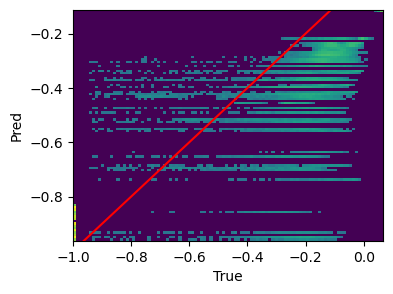

c:\Users\wzh41\anaconda3\envs\pytorch\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


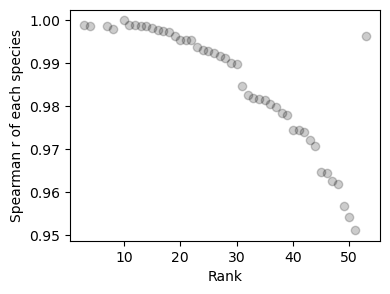

In [62]:
true_x_list = []
recon_x_list = []
n_batch_use = 100

true_x_list = y_test_scaled.numpy()
recon_x_list = y_pred_en
plt.figure(figsize=(4, 3))
plt.hist2d(x=true_x_list.flatten(), y=recon_x_list.flatten(), norm=matplotlib.colors.PowerNorm(1/10), cmap='viridis', bins=100)
plt.plot([-1.0, 0.2], [-1.0, 0.2], color="r")
plt.xlabel("True")
plt.ylabel("Pred")
plt.show()

# spearman r by species
coeffs = [ stats.pearsonr(true_x_list[:, i], recon_x_list[:, i]) for i in range(true_x_list.shape[1]) ]
coeffs_sorted = sorted(enumerate(coeffs), key=lambda x: x[1], reverse=True)
plt.figure(figsize=(4, 3))
plt.scatter(range(len(coeffs)), [val[0] for (idx, val) in coeffs_sorted], color="k", alpha=0.2)
plt.xlabel("Rank")
plt.ylabel("Spearman r of each species")
plt.show()

In [44]:
stats.pearsonr(recon_x_list.flatten(), true_x_list.flatten())

PearsonRResult(statistic=0.9898247276395034, pvalue=0.0)

#### Interactions

I don't know what's the best way to quantify the interaction strength here for a cross-feeding CRM. I'm trying to do the following:

Consumption $C_{\alpha i} = \left(\frac{\partial \dot{R_i}}{\partial N_\alpha}\right)_{\text{consume}}=(1-f)g_{\alpha i}R_i$

Prodution $P_{\alpha i} = \left(\frac{\partial \dot{R_i}}{\partial N_\alpha}\right)_{\text{produce}}=f\sum_j D^{\alpha}_{j\to i}g_{\alpha j} R_j$

Facilitation $A_{\text{facil}}=C\cdot P^T$

Competition $A_{\text{comp}}=-C\cdot C^T$

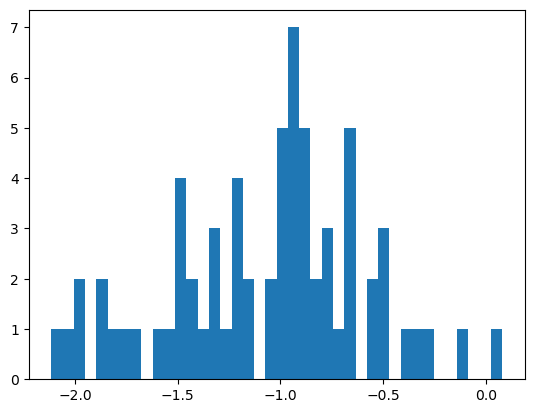

In [87]:
params = pickle.load(open("synthetic data/parameters.pkl", "rb"))
gs = params[0]["g"]
plt.hist(np.log10(np.sum(params[0]["g"], axis=1)), bins=40)
plt.show()

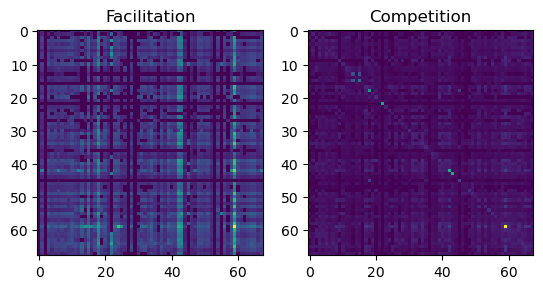

In [ ]:
# consumption matrix
def make_c(params, f, Rs):
    n_spc = params["g"].shape[0]
    return (1-f)*params["g"]*np.outer(np.ones(n_spc), Rs)

# production matrix
def make_p(params, f, Rs):
    n_res = Rs.shape[0]
    c, g, p, o = params["c"], params["g"], params["p"], params["o"]
    caj_gaj_oa_Rj = c * g * np.outer(o, Rs)
    return p * f * np.outer(np.sum(caj_gaj_oa_Rj, axis=1), np.ones(n_res))

def mat_facil(params, f, Rs):
    c = make_c(params, f, Rs)
    p = make_p(params, f, Rs)
    return c @ (p.T)

def mat_comp(params, f, Rs):
    c = make_c(params, f, Rs)
    return -c @ (c.T)

all_Rs = pickle.load(open("synthetic data/all_diets_Rs.pkl", "rb"))
all_Rs = all_Rs*(all_Rs>0)
# an example
Rs = all_Rs.loc[0]
a_facil = mat_facil(params[0], 0.9, Rs)
a_comp = mat_comp(params[0], 0.9, Rs)
plt.subplot(1, 2, 1)
plt.imshow(a_facil**(1/5), cmap='viridis')
plt.title("Facilitation")
plt.subplot(1, 2, 2)
plt.imshow((-a_comp)**(1/5))
plt.title("Competition")
plt.show()

100%|██████████| 10000/10000 [00:02<00:00, 3511.85it/s]


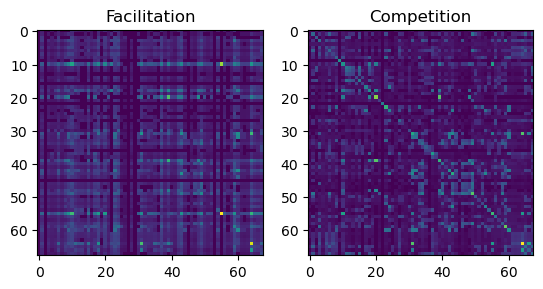

In [184]:
# for all circumstances
a_facil = np.zeros((params[0]["g"].shape[0], params[0]["g"].shape[0]))
a_comp = np.zeros((params[0]["g"].shape[0], params[0]["g"].shape[0]))
for i in tqdm(range(all_Rs.shape[0])):
    Rs = all_Rs.loc[i]
    a_facil += mat_facil(params[0], 0.9, Rs)/all_Rs.shape[0]
    a_comp += mat_comp(params[0], 0.9, Rs)/all_Rs.shape[0]
plt.subplot(1, 2, 1)
plt.imshow(a_facil**(1/5), cmap='viridis')
plt.title("Facilitation")
plt.subplot(1, 2, 2)
plt.imshow((-a_comp)**(1/5))
plt.title("Competition")
plt.show()

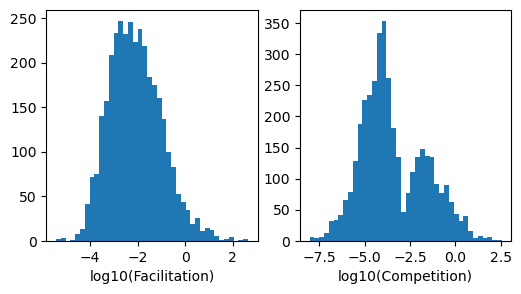

In [195]:
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.hist(np.log10(a_facil[a_facil>0]), bins=40)
plt.xlabel("log10(Facilitation)")
plt.subplot(1, 2, 2)
plt.hist(np.log10(-a_comp[a_comp<0]), bins=40)
plt.xlabel("log10(Competition)")
plt.show()